In [85]:
import gradio as gr
import numpy as np
import IPython
from IPython.display import Audio, display
import torch
import librosa, librosa.display
from tqdm import tqdm
from stqdm import stqdm
import json

import sys  
sys.path.insert(0, '../')
from audioldm2 import text_to_audio, build_model, seed_everything, make_batch_for_text_to_audio
from audioldm2.latent_diffusion.modules.diffusionmodules.util import (
    make_ddim_sampling_parameters,
    make_ddim_timesteps,
    noise_like,
    extract_into_tensor,
)
from audioldm2.latent_diffusion.models.ddim import DDIMSampler
from audioldm2.utilities import *
from audioldm2.utilities.audio import *
from audioldm2.utilities.data import *
from audioldm2.utils import default_audioldm_config

from audioldm2.gaverutils import gaver_sounds

from audioldm2.latent_diffusion.modules.attention import SpatialTransformer, CrossAttention

from einops import rearrange, repeat

from scipy.stats import pearsonr, ttest_ind


from interfaces.diffusion_helper_qkv import *


import random

import soundfile as sf

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [4]:
def get_model(model_name):
    print('Loading model')
    
    latent_diffusion = build_model(model_name=model_name)
    latent_diffusion.latent_t_size = int(duration * latent_t_per_second)

    print('Model loaded')
    return latent_diffusion


In [5]:
model_name = 'audioldm_16k_crossattn_t5'
latent_t_per_second=25.6
sample_rate=16000
duration = 10.0 #Duration is minimum 10 secs. The generated sounds are weird for <10secs
guidance_scale = 3
random_seed = 42
n_candidates = 1
batch_size = 1
ddim_steps = 20

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'ti

/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 265.53 M params.


/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model loaded


In [6]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
def get_word_pairs():
    adjective_noun_pairs = []
    verb_noun_pairs = []

    with open('AudioPairBank/adjective_noun_pairs.txt') as f:
        adjective_noun_pairs_str = f.read()

    with open('AudioPairBank/verb_noun_pairs.txt') as f:
        verb_noun_pairs_str = f.read()

    adjective_noun_pairs = adjective_noun_pairs_str.split("\n")
    verb_noun_pairs = verb_noun_pairs_str.split("\n")

    return np.array(adjective_noun_pairs), np.array(verb_noun_pairs)

adjective_noun_pairs, verb_noun_pairs = get_word_pairs()

In [8]:
# adjective_noun_pairs

In [9]:
len(adjective_noun_pairs), len(verb_noun_pairs)

(759, 359)

In [10]:
def score_wav_text(wav_arr, text, random_seed, is_reverse=False): #return change in score and pearson corr
    seed_everything(random_seed)
    score_list = []
    for ind, wav in enumerate(wavs):
        wav = torch.from_numpy(wav).unsqueeze(dim=0).cuda()
        score = latent_diffusion.clap.cos_similarity(wav, text)
        # print(ind, score)
        score_list.append(score.detach().cpu())

    change_in_score = torch.abs(score_list[0] - score_list[-1])
    if not is_reverse:
        corr = np.abs(pearsonr(score_list, np.arange(0, len(score_list), 1)).statistic)
    else:
        corr = np.abs(pearsonr(score_list, np.arange(len(score_list), 0, -1)).statistic)

    return change_in_score, corr, score_list

# Morphing

In [11]:
num_bootstrap = 100
num_bootstrap_choices = 50
random_seed = 42

In [12]:
def create_samples(num_choices=1, source_type="adjective", target_type="adjective"):
    source_pairs_choices = []
    target_pairs_choices = []
    dir_p = ""
    if source_type == 'adjective':
        source_pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
        if target_type == 'adjective':
            target_pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
            dir_p = os.path.join('samples_morph_2', 'adjective_noun_to_adjective_noun')
        else:
            target_pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
            dir_p = os.path.join('samples_morph_2', 'adjective_noun_to_verb_noun')
    elif source_type == 'verb':
        source_pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
        if target_type == 'verb':
            target_pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
            dir_p = os.path.join('samples_morph_2', 'verb_noun_to_verb_noun')
        else:
            target_pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
            dir_p = os.path.join('samples_morph_2', 'verb_noun_to_adjective_noun')

    os.makedirs(dir_p, exist_ok=True)
    for source_ind, source_pairs_choice in enumerate(source_pairs_choices):
        target_pairs_choice = target_pairs_choices[source_ind]

        if source_pairs_choice is not None and source_pairs_choice != "" and \
        target_pairs_choice is not None and target_pairs_choice != "":
            print(source_pairs_choice, target_pairs_choice)

            source_pairs_choice_txt = source_pairs_choice
            target_pairs_choice_txt = target_pairs_choice

            for i in np.arange(0,1.1,0.1):
                predicted_wav, _ = sample_diffusion_attention_core(source_text=source_pairs_choice_txt, target_text=target_pairs_choice_txt, random_seed=random_seed, ddim_steps=20,\
                                                       latent_diffusion=latent_diffusion,
                                                       interpolation_level = i,
                                                       interpolate_terms = ['q','k','v'],
                                                       disable_tqdmoutput = True
                                                       )
               
                fname = source_pairs_choice.replace(" ","_")+"_to_"+target_pairs_choice.replace(" ","_")
                fname += "_"+'{0:.1f}'.format(i)+".wav"
                
                sf.write(os.path.join(dir_p, fname), predicted_wav, samplerate=16000) 

In [24]:
def create_samples_2(dir_p, source_pairs_choices, target_pairs_choices):
    os.makedirs(dir_p, exist_ok=True)
    for source_ind, source_pairs_choice in enumerate(source_pairs_choices):
        target_pairs_choice = target_pairs_choices[source_ind]

        if source_pairs_choice is not None and source_pairs_choice != "" and \
        target_pairs_choice is not None and target_pairs_choice != "":
            print(source_pairs_choice, target_pairs_choice)

            source_pairs_choice_txt = source_pairs_choice
            target_pairs_choice_txt = target_pairs_choice

            for i in np.arange(0,1.1,0.1):
                predicted_wav, _ = sample_diffusion_attention_core(source_text=source_pairs_choice_txt, target_text=target_pairs_choice_txt, random_seed=random_seed, ddim_steps=20,\
                                                       latent_diffusion=latent_diffusion,
                                                       interpolation_level = i,
                                                       interpolate_terms = ['q','k','v'],
                                                       disable_tqdmoutput = True
                                                       )
               
                fname = source_pairs_choice.replace(" ","_")+"_to_"+target_pairs_choice.replace(" ","_")
                fname += "_"+'{0:.1f}'.format(i)+".wav"
                
                sf.write(os.path.join(dir_p, fname), predicted_wav, samplerate=16000) 

In [83]:
dirp = "/media/appdir2/Github/audioldm2/eval/samples_morph_2/verb_noun_to_verb_noun"

nlist=[]
for f in os.listdir(dirp):
    tokens = "_".join(f.split(".wav")[0].split("_")[:-1])
    nlist.append(tokens)
nlist = np.unique(np.array(nlist))
print('Unique = ', len(nlist))

a_map = {}
for f in os.listdir(dirp):
    tokens = "_".join(f.split(".wav")[0].split("_")[:-1])

    if tokens in a_map:
        a_map[tokens] = a_map[tokens]+1
    else:
        a_map[tokens] = 0
a_map, len(a_map)

Unique =  50


({'whistling_train_to_ringing_ball': 10,
  'whistling_bird_to_passing_airplane': 10,
  'flying_engine_to_whispering_speech': 10,
  'clicking_fire_to_splashing_fountain': 10,
  'crackling_footsteps_to_breaking_wood': 10,
  'talking_computer_to_clicking_tick': 10,
  'clicking_computer_to_ringing_phone': 10,
  'falling_wind_to_talking_voice': 10,
  'splashing_rain_to_crackling_fire': 10,
  'walking_dog_to_howling_wind': 10,
  'falling_noise_to_opening_coke': 10,
  'whispering_english_to_whispering_monster': 10,
  'banging_war_to_accelerating_engine': 10,
  'whining_noise_to_clicking_office': 10,
  'braking_car_to_opening_trash': 10,
  'crying_woman_to_growling_creatures': 10,
  'rolling_thunder_to_passing_ship': 10,
  'falling_coin_to_opening_window': 10,
  'crying_animal_to_falling_rock': 10,
  'growling_scream_to_banging_door': 10,
  'breathing_woman_to_laughing_speech': 10,
  'squeaking_metal_to_crackling_snow': 10,
  'screaming_voice_to_growling_scream': 10,
  'ringing_clock_to_crying

## Adjective Noun to Adjective Noun morphing

In [105]:
num_choices = 200
source_pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
target_pairs_choices = np.random.choice(adjective_noun_pairs, num_choices, replace=False)
dir_p = os.path.join('samples_morph_2', 'verb_noun_to_verb_noun')

In [106]:
create_samples_2(dir_p, source_pairs_choices[100:105], target_pairs_choices[100:105])
time.sleep(30)

evil monster windy tree
weird noise distant atmosphere
funny guitar scary english
heavy rock annoying computer
strange suspense slow sound


## Verb Noun to Verb Noun morphing

In [25]:
num_choices = 50
source_pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
target_pairs_choices = np.random.choice(verb_noun_pairs, num_choices, replace=False)
dir_p = os.path.join('samples_morph_2', 'verb_noun_to_verb_noun')

In [32]:
create_samples_2(dir_p, source_pairs_choices[20:25], target_pairs_choices[20:25])

growling dragon passing engine
ringing glass starting car
walking crowd falling water
breaking glasses falling wood
talking alien opening ship


In [33]:
import time

create_samples_2(dir_p, source_pairs_choices[25:30], target_pairs_choices[25:30])
time.sleep(30)
create_samples_2(dir_p, source_pairs_choices[30:35], target_pairs_choices[30:35])
time.sleep(30)
create_samples_2(dir_p, source_pairs_choices[35:40], target_pairs_choices[35:40])
time.sleep(30)
create_samples_2(dir_p, source_pairs_choices[40:45], target_pairs_choices[40:45])
time.sleep(30)
create_samples_2(dir_p, source_pairs_choices[45:50], target_pairs_choices[45:50])



ringing clock crying dog
growling scream banging door
walking dog howling wind
braking car opening trash
crackling footsteps breaking wood
splashing rain crackling fire
banging construction banging thunder
whispering speech starting machine
growling voice talking woman
falling noise opening coke
breaking wood ticking bell
banging war accelerating engine
whistling bird passing airplane
crying woman growling creatures
crying man crackling thunder
opening book rolling metal
breaking egg talking lady
talking german rolling coin
falling coin opening window
gurgling toilet clicking car
rolling thunder passing ship
clicking computer ringing phone
banging bird dripping metal
breathing woman laughing speech
whispering english whispering monster


In [34]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Evaluate Adjective Nouns to Adjective Nouns morph

In [107]:
dir_p = os.path.join('samples_morph_2', 'adjective_noun_to_adjective_noun')

adjective_noun_to_adjective_noun_list = []
for f in os.listdir(dir_p):
    tokens = "_".join(f.split(".wav")[0].split("_")[:-1])
    adjective_noun_to_adjective_noun_list.append(tokens)
adjective_noun_to_adjective_noun_list = np.unique(np.array(adjective_noun_to_adjective_noun_list))

left_list = []
right_list = []
for f in adjective_noun_to_adjective_noun_list:
    tokens = f.split(".")[0].split("_to_")
    left_list.append(tokens[0])
    right_list.append(tokens[1])


left_clap_score_change_list = []
left_perceptual_lin_score_list = []
left_all_score_list = []

right_clap_score_change_list = []
right_perceptual_lin_score_list = []
right_all_score_list = []

for left_ind, left_text in enumerate(left_list):
    right_text = right_list[left_ind]

    wavs = []
    for i in np.arange(0,1.1,0.1):
        i_str = '{0:.1f}'.format(i)
        fname = os.path.join(dir_p, left_text+"_to_"+right_text+"_"+i_str+".wav")
        audio, _ = librosa.load(fname, sr=16000)
        wavs.append(audio)

    left_text = left_text.replace("_", " ")
    change_in_score_1, perceptual_lin_1, score_list_1 = score_wav_text(wavs, left_text, random_seed=random_seed,is_reverse=True)
    left_clap_score_change_list.append(change_in_score_1)
    left_perceptual_lin_score_list.append(perceptual_lin_1)
    left_all_score_list.append(torch.stack(score_list_1))

    right_text = right_text.replace("_", " ")
    change_in_score_2, perceptual_lin_2, score_list_2 = score_wav_text(wavs, right_text, random_seed=random_seed)
    right_clap_score_change_list.append(change_in_score_2)
    right_perceptual_lin_score_list.append(perceptual_lin_2)
    right_all_score_list.append(torch.stack(score_list_2))


left_clap_score_change_list = torch.stack(left_clap_score_change_list)
left_perceptual_lin_score_list = np.array(left_perceptual_lin_score_list)

right_clap_score_change_list = torch.stack(right_clap_score_change_list)
right_perceptual_lin_score_list = np.array(right_perceptual_lin_score_list)

left_all_score_list = torch.stack(left_all_score_list)
left_all_score_list_mean = torch.mean(left_all_score_list, dim=0)
left_all_score_list_std = torch.std(left_all_score_list, dim=0)
right_all_score_list = torch.stack(right_all_score_list)
right_all_score_list_mean = torch.mean(right_all_score_list, dim=0)
right_all_score_list_std = torch.std(right_all_score_list, dim=0)

print("-----Left------")
print("Mean CLAP score change = ", str(torch.mean(left_clap_score_change_list).numpy())+"+/-"+str(torch.std(left_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(left_perceptual_lin_score_list))+"+/-"+str(np.std(left_perceptual_lin_score_list)))
print("All score average per step = ", left_all_score_list_mean)
print("All score std per step = ", left_all_score_list_std)
print("---------------")
print("-----Right------")
print("Mean CLAP score change = ", str(torch.mean(right_clap_score_change_list).numpy())+"+/-"+str(torch.std(right_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(right_perceptual_lin_score_list))+"+/-"+str(np.std(right_perceptual_lin_score_list)))
print("All score average per step = ", right_all_score_list_mean)
print("All score std per step = ", right_all_score_list_std)
print("---------------")


for ind, adjective_noun_to_adjective_noun in enumerate(adjective_noun_to_adjective_noun_list):
    print(adjective_noun_to_adjective_noun, \
          left_clap_score_change_list[ind], left_perceptual_lin_score_list[ind], \
          right_clap_score_change_list[ind], right_perceptual_lin_score_list[ind])

-----Left------
Mean CLAP score change =  0.1245031+/-0.10784953
Mean corr =  0.7104514402716879+/-0.23765937352284353
All score average per step =  tensor([0.1450, 0.1408, 0.1322, 0.1230, 0.1095, 0.0747, 0.0599, 0.0545, 0.0538,
        0.0493, 0.0431])
All score std per step =  tensor([0.1214, 0.1214, 0.1157, 0.1173, 0.1213, 0.1030, 0.1013, 0.0999, 0.1060,
        0.1106, 0.1058])
---------------
-----Right------
Mean CLAP score change =  0.12595731+/-0.08486428
Mean corr =  0.7578712489528895+/-0.22671705757605803
All score average per step =  tensor([0.0567, 0.0597, 0.0650, 0.0766, 0.0958, 0.1210, 0.1344, 0.1446, 0.1437,
        0.1520, 0.1444])
All score std per step =  tensor([0.1150, 0.1161, 0.1197, 0.1278, 0.1239, 0.1209, 0.1144, 0.1194, 0.1169,
        0.1155, 0.1104])
---------------
calm_winter_to_industrial_engine tensor(0.3237) 0.947528897555994 tensor(0.1528) 0.8333527114982182
crazy_noise_to_evil_alien tensor(0.0754) 0.47959061334911385 tensor(0.1775) 0.8657233062595809
c

# Bootstrapped Adjective Noun to Adjective Noun Morph scores

In [108]:
len_arr = len(adjective_noun_to_adjective_noun_list)

left_bootstrap_clap_score_change_list = []
left_bootstrap_perceptual_lin_score_list = []
left_bootstrap_all_score_list = []

right_bootstrap_clap_score_change_list = []
right_bootstrap_perceptual_lin_score_list = []
right_bootstrap_all_score_list = []
for bootstrap_ind in range(num_bootstrap):
    ind_choices = np.random.choice(np.arange(len_arr), 2, replace=False)
    
    left_clap_score_change_sublist = left_clap_score_change_list[ind_choices]
    left_perceptual_lin_score_sublist = left_perceptual_lin_score_list[ind_choices]
    left_clap_all_score_sublist = left_all_score_list[ind_choices]
    
    left_bootstrap_clap_score_change_list.append(torch.mean(left_clap_score_change_sublist))
    left_bootstrap_perceptual_lin_score_list.append(np.mean(left_perceptual_lin_score_sublist))
    left_bootstrap_all_score_list.append(torch.mean(left_clap_all_score_sublist, dim=0))

    
    right_clap_score_change_sublist = right_clap_score_change_list[ind_choices]
    right_perceptual_lin_score_sublist = right_perceptual_lin_score_list[ind_choices]
    right_clap_all_score_sublist = right_all_score_list[ind_choices]

    right_bootstrap_clap_score_change_list.append(torch.mean(right_clap_score_change_sublist))
    right_bootstrap_perceptual_lin_score_list.append(np.mean(right_perceptual_lin_score_sublist))
    right_bootstrap_all_score_list.append(torch.mean(right_clap_all_score_sublist, dim=0))

left_bootstrap_clap_score_change_list = torch.stack(left_bootstrap_clap_score_change_list)
left_bootstrap_perceptual_lin_score_list = np.array(left_bootstrap_perceptual_lin_score_list)

right_bootstrap_clap_score_change_list = torch.stack(right_bootstrap_clap_score_change_list)
right_bootstrap_perceptual_lin_score_list = np.array(right_bootstrap_perceptual_lin_score_list)

left_bootstrap_all_score_list = torch.stack(left_bootstrap_all_score_list)
left_bootstrap_all_score_list_mean = torch.mean(left_bootstrap_all_score_list, dim=0)
left_bootstrap_all_score_list_std = torch.std(left_bootstrap_all_score_list, dim=0)
right_bootstrap_all_score_list = torch.stack(right_bootstrap_all_score_list)
right_bootstrap_all_score_list_mean = torch.mean(right_bootstrap_all_score_list, dim=0)
right_bootstrap_all_score_list_std = torch.std(right_bootstrap_all_score_list, dim=0)

print("-----Left------")
print("Mean CLAP score change = ", str(torch.mean(left_bootstrap_clap_score_change_list).numpy())+"+/-"+str(torch.std(left_bootstrap_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(left_bootstrap_perceptual_lin_score_list))+"+/-"+str(np.std(left_bootstrap_perceptual_lin_score_list)))
print("All score average per step = ", left_bootstrap_all_score_list_mean)
print("All score std per step = ", left_bootstrap_all_score_list_std)
print("---------------")
print("-----Right------")
print("Mean CLAP score change = ", str(torch.mean(right_clap_score_change_list).numpy())+"+/-"+str(torch.std(right_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(right_perceptual_lin_score_list))+"+/-"+str(np.std(right_perceptual_lin_score_list)))
print("All score average per step = ", right_bootstrap_all_score_list_mean)
print("All score std per step = ", right_bootstrap_all_score_list_std)
print("---------------")



adj_noun_left_mean = left_bootstrap_all_score_list_mean
adj_noun_left_std = left_bootstrap_all_score_list_std
adj_noun_right_mean = right_bootstrap_all_score_list_mean
adj_noun_right_std = right_bootstrap_all_score_list_std

-----Left------
Mean CLAP score change =  0.12200812+/-0.074579805
Mean corr =  0.7059466947020848+/-0.15325084642019166
All score average per step =  tensor([0.1419, 0.1362, 0.1299, 0.1229, 0.1099, 0.0702, 0.0537, 0.0508, 0.0494,
        0.0463, 0.0393])
All score std per step =  tensor([0.0823, 0.0844, 0.0795, 0.0843, 0.0926, 0.0780, 0.0751, 0.0745, 0.0756,
        0.0774, 0.0757])
---------------
-----Right------
Mean CLAP score change =  0.12595731+/-0.08486428
Mean corr =  0.7578712489528895+/-0.22671705757605803
All score average per step =  tensor([0.0574, 0.0608, 0.0655, 0.0784, 0.0960, 0.1222, 0.1360, 0.1465, 0.1452,
        0.1513, 0.1456])
All score std per step =  tensor([0.0907, 0.0920, 0.0907, 0.0953, 0.0850, 0.0821, 0.0817, 0.0810, 0.0766,
        0.0785, 0.0792])
---------------


## t-test

In [109]:
ttest_ind(left_all_score_list[:,0], left_all_score_list[:,-1])

Ttest_indResult(statistic=4.336586233140717, pvalue=3.6988577668832134e-05)

In [110]:
ttest_ind(right_all_score_list[:,0], right_all_score_list[:,-1])

Ttest_indResult(statistic=-3.7722173100829672, pvalue=0.0002859768934280229)

In [111]:
ttest_ind(left_all_score_list[:,0], right_all_score_list[:,0])

Ttest_indResult(statistic=3.6194597038453957, pvalue=0.0004824863633064518)

In [112]:
ttest_ind(left_all_score_list[:,-1], right_all_score_list[:,-1])

Ttest_indResult(statistic=-4.541271503483249, pvalue=1.6913498168233043e-05)

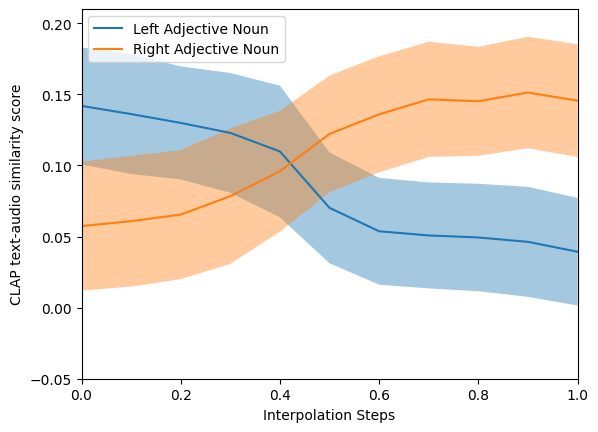

In [113]:
fig, ax = plt.subplots(1)

left_mean = adj_noun_left_mean
left_std = adj_noun_left_std
right_mean = adj_noun_right_mean
right_std = adj_noun_right_std

ax.plot(np.arange(0,1.1,.1), left_mean,  label='Left Adjective Noun')
ax.fill_between(np.arange(0,1.1,.1), left_mean+(left_std/2), left_mean-(left_std/2), alpha=0.4)

ax.plot(np.arange(0,1.1,.1), right_mean,  label='Right Adjective Noun')
ax.fill_between(np.arange(0,1.1,.1), right_mean+(right_std/2), right_mean-(right_std/2), alpha=0.4)

ax.legend(loc='upper left')
ax.set_xlabel('Interpolation Steps')
ax.set_ylabel('CLAP text-audio similarity score')
ax.set_xlim([0,1])
ax.set_ylim([-0.05,0.21])
ax.set_yticks([i for i in np.arange(-0.05,0.21,0.05)])

# Evaluate Verb Noun to Verb Noun Morph

In [99]:
dir_p = os.path.join('samples_morph_2', 'verb_noun_to_verb_noun')

verb_noun_to_verb_noun_list = []
for f in os.listdir(dir_p):
    tokens = "_".join(f.split(".wav")[0].split("_")[:-1])
    verb_noun_to_verb_noun_list.append(tokens)
verb_noun_to_verb_noun_list = np.unique(np.array(verb_noun_to_verb_noun_list))

left_list = []
right_list = []
for f in verb_noun_to_verb_noun_list:
    tokens = f.split(".")[0].split("_to_")
    left_list.append(tokens[0])
    right_list.append(tokens[1])


left_clap_score_change_list = []
left_perceptual_lin_score_list = []
left_all_score_list = []

right_clap_score_change_list = []
right_perceptual_lin_score_list = []
right_all_score_list = []

for left_ind, left_text in enumerate(left_list):
    right_text = right_list[left_ind]

    wavs = []
    for i in np.arange(0,1.1,0.1):
        i_str = '{0:.1f}'.format(i)
        fname = os.path.join(dir_p, left_text+"_to_"+right_text+"_"+i_str+".wav")
        audio, _ = librosa.load(fname, sr=16000)
        wavs.append(audio)

    left_text = left_text.replace("_", " ")
    change_in_score_1, perceptual_lin_1, score_list_1 = score_wav_text(wavs, left_text, random_seed=random_seed,is_reverse=True)
    left_clap_score_change_list.append(change_in_score_1)
    left_perceptual_lin_score_list.append(perceptual_lin_1)
    left_all_score_list.append(torch.stack(score_list_1))

    right_text = right_text.replace("_", " ")
    change_in_score_2, perceptual_lin_2, score_list_2 = score_wav_text(wavs, right_text, random_seed=random_seed)
    right_clap_score_change_list.append(change_in_score_2)
    right_perceptual_lin_score_list.append(perceptual_lin_2)
    right_all_score_list.append(torch.stack(score_list_2))


left_clap_score_change_list = torch.stack(left_clap_score_change_list)
left_perceptual_lin_score_list = np.array(left_perceptual_lin_score_list)

right_clap_score_change_list = torch.stack(right_clap_score_change_list)
right_perceptual_lin_score_list = np.array(right_perceptual_lin_score_list)

left_all_score_list = torch.stack(left_all_score_list)
left_all_score_list_mean = torch.mean(left_all_score_list, dim=0)
left_all_score_list_std = torch.std(left_all_score_list, dim=0)
right_all_score_list = torch.stack(right_all_score_list)
right_all_score_list_mean = torch.mean(right_all_score_list, dim=0)
right_all_score_list_std = torch.std(right_all_score_list, dim=0)

print("-----Left------")
print("Mean CLAP score change = ", str(torch.mean(left_clap_score_change_list).numpy())+"+/-"+str(torch.std(left_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(left_perceptual_lin_score_list))+"+/-"+str(np.std(left_perceptual_lin_score_list)))
print("All score average per step = ", left_all_score_list_mean)
print("All score std per step = ", left_all_score_list_std)
print("---------------")
print("-----Right------")
print("Mean CLAP score change = ", str(torch.mean(right_clap_score_change_list).numpy())+"+/-"+str(torch.std(right_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(right_perceptual_lin_score_list))+"+/-"+str(np.std(right_perceptual_lin_score_list)))
print("All score average per step = ", right_all_score_list_mean)
print("All score std per step = ", right_all_score_list_std)
print("---------------")

for ind, verb_noun_to_verb_noun in enumerate(verb_noun_to_verb_noun_list):
    print(verb_noun_to_verb_noun, \
          left_clap_score_change_list[ind], left_perceptual_lin_score_list[ind], \
          right_clap_score_change_list[ind], right_perceptual_lin_score_list[ind])

-----Left------
Mean CLAP score change =  0.14123678+/-0.09265431
Mean corr =  0.7467437780641536+/-0.22169572514835995
All score average per step =  tensor([0.1323, 0.1257, 0.1184, 0.1056, 0.1018, 0.0802, 0.0647, 0.0394, 0.0181,
        0.0121, 0.0102])
All score std per step =  tensor([0.0873, 0.0838, 0.0817, 0.0906, 0.1052, 0.1110, 0.1020, 0.0960, 0.1010,
        0.0982, 0.0964])
---------------
-----Right------
Mean CLAP score change =  0.16488752+/-0.08971218
Mean corr =  0.7882004696660587+/-0.20802812464800433
All score average per step =  tensor([-0.0048,  0.0054,  0.0096,  0.0320,  0.0543,  0.0854,  0.1086,  0.1298,
         0.1370,  0.1469,  0.1502])
All score std per step =  tensor([0.0888, 0.0875, 0.0879, 0.0959, 0.1027, 0.1080, 0.1051, 0.0960, 0.0959,
        0.0978, 0.0944])
---------------
banging_bird_to_dripping_metal tensor(0.1626) 0.9677499644063698 tensor(0.0834) 0.6546126600527997
banging_construction_to_banging_thunder tensor(0.0709) 0.9256525765052289 tensor(0.00

## t-test

In [101]:
ttest_ind(left_all_score_list[:,0], left_all_score_list[:,-1])

Ttest_indResult(statistic=6.641135728230762, pvalue=1.7473219580837012e-09)

In [102]:
ttest_ind(right_all_score_list[:,0], right_all_score_list[:,-1])

Ttest_indResult(statistic=-8.453764707082835, pvalue=2.7036884297445156e-13)

In [103]:
ttest_ind(left_all_score_list[:,0], right_all_score_list[:,0])

Ttest_indResult(statistic=7.784225917381224, pvalue=7.30104721922867e-12)

In [104]:
ttest_ind(left_all_score_list[:,-1], right_all_score_list[:,-1])

Ttest_indResult(statistic=-7.338021798155063, pvalue=6.36791065587993e-11)

# Bootstrapped Verb Noun to Verb Noun morph scores

In [100]:
len_arr = len(verb_noun_to_verb_noun_list)

left_bootstrap_clap_score_change_list = []
left_bootstrap_perceptual_lin_score_list = []
left_bootstrap_all_score_list = []

right_bootstrap_clap_score_change_list = []
right_bootstrap_perceptual_lin_score_list = []
right_bootstrap_all_score_list = []
for bootstrap_ind in range(num_bootstrap):
    ind_choices = np.random.choice(np.arange(len_arr), 2, replace=False)
    
    left_clap_score_change_sublist = left_clap_score_change_list[ind_choices]
    left_perceptual_lin_score_sublist = left_perceptual_lin_score_list[ind_choices]
    left_clap_all_score_sublist = left_all_score_list[ind_choices]
    
    left_bootstrap_clap_score_change_list.append(torch.mean(left_clap_score_change_sublist))
    left_bootstrap_perceptual_lin_score_list.append(np.mean(left_perceptual_lin_score_sublist))
    left_bootstrap_all_score_list.append(torch.mean(left_clap_all_score_sublist, dim=0))

    
    right_clap_score_change_sublist = right_clap_score_change_list[ind_choices]
    right_perceptual_lin_score_sublist = right_perceptual_lin_score_list[ind_choices]
    right_clap_all_score_sublist = right_all_score_list[ind_choices]

    right_bootstrap_clap_score_change_list.append(torch.mean(right_clap_score_change_sublist))
    right_bootstrap_perceptual_lin_score_list.append(np.mean(right_perceptual_lin_score_sublist))
    right_bootstrap_all_score_list.append(torch.mean(right_clap_all_score_sublist, dim=0))

left_bootstrap_clap_score_change_list = torch.stack(left_bootstrap_clap_score_change_list)
left_bootstrap_perceptual_lin_score_list = np.array(left_bootstrap_perceptual_lin_score_list)

right_bootstrap_clap_score_change_list = torch.stack(right_bootstrap_clap_score_change_list)
right_bootstrap_perceptual_lin_score_list = np.array(right_bootstrap_perceptual_lin_score_list)

left_bootstrap_all_score_list = torch.stack(left_bootstrap_all_score_list)
left_bootstrap_all_score_list_mean = torch.mean(left_bootstrap_all_score_list, dim=0)
left_bootstrap_all_score_list_std = torch.std(left_bootstrap_all_score_list, dim=0)
right_bootstrap_all_score_list = torch.stack(right_bootstrap_all_score_list)
right_bootstrap_all_score_list_mean = torch.mean(right_bootstrap_all_score_list, dim=0)
right_bootstrap_all_score_list_std = torch.std(right_bootstrap_all_score_list, dim=0)

print("-----Left------")
print("Mean CLAP score change = ", str(torch.mean(left_bootstrap_clap_score_change_list).numpy())+"+/-"+str(torch.std(left_bootstrap_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(left_bootstrap_perceptual_lin_score_list))+"+/-"+str(np.std(left_bootstrap_perceptual_lin_score_list)))
print("All score average per step = ", left_bootstrap_all_score_list_mean)
print("All score std per step = ", left_bootstrap_all_score_list_std)
print("---------------")
print("-----Right------")
print("Mean CLAP score change = ", str(torch.mean(right_clap_score_change_list).numpy())+"+/-"+str(torch.std(right_clap_score_change_list).numpy()))
print("Mean corr = ", str(np.mean(right_perceptual_lin_score_list))+"+/-"+str(np.std(right_perceptual_lin_score_list)))
print("All score average per step = ", right_bootstrap_all_score_list_mean)
print("All score std per step = ", right_bootstrap_all_score_list_std)
print("---------------")



verb_noun_left_mean = left_bootstrap_all_score_list_mean
verb_noun_left_std = left_bootstrap_all_score_list_std
verb_noun_right_mean = right_bootstrap_all_score_list_mean
verb_noun_right_std = right_bootstrap_all_score_list_std

-----Left------
Mean CLAP score change =  0.13334766+/-0.06035477
Mean corr =  0.7247810478569024+/-0.1595141180453854
All score average per step =  tensor([0.1313, 0.1259, 0.1161, 0.1064, 0.1024, 0.0887, 0.0725, 0.0451, 0.0214,
        0.0145, 0.0132])
All score std per step =  tensor([0.0565, 0.0562, 0.0551, 0.0606, 0.0689, 0.0706, 0.0636, 0.0605, 0.0605,
        0.0595, 0.0595])
---------------
-----Right------
Mean CLAP score change =  0.16488752+/-0.08971218
Mean corr =  0.7882004696660587+/-0.20802812464800433
All score average per step =  tensor([-0.0081,  0.0013,  0.0067,  0.0274,  0.0494,  0.0841,  0.1086,  0.1294,
         0.1338,  0.1446,  0.1482])
All score std per step =  tensor([0.0618, 0.0615, 0.0619, 0.0673, 0.0722, 0.0698, 0.0662, 0.0608, 0.0636,
        0.0668, 0.0651])
---------------


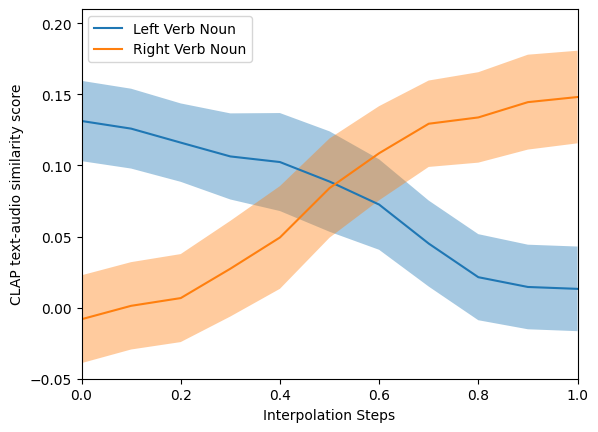

In [79]:
fig, ax = plt.subplots(1)

left_mean = verb_noun_left_mean
left_std = verb_noun_left_std
right_mean = verb_noun_right_mean
right_std = verb_noun_right_std

ax.plot(np.arange(0,1.1,.1), left_mean,  label='Left Verb Noun')
ax.fill_between(np.arange(0,1.1,.1), left_mean+(left_std/2), left_mean-(left_std/2), alpha=0.4)

ax.plot(np.arange(0,1.1,.1), right_mean,  label='Right Verb Noun')
ax.fill_between(np.arange(0,1.1,.1), right_mean+(right_std/2), right_mean-(right_std/2), alpha=0.4)

ax.legend(loc='upper left')
ax.set_xlabel('Interpolation Steps')
ax.set_ylabel('CLAP text-audio similarity score')
ax.set_xlim([0,1])
ax.set_ylim([-0.05,0.21])
ax.set_yticks([i for i in np.arange(-0.05,0.21,0.05)])